In [21]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq

In [13]:
#Plotting Options
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"

In [2]:
#choose filepath to desired data
path = '/Volumes/KESU/may19/polarized/'

# Import Calibration Data

Import hdf5 data generated from calculate_POL 

In [46]:
with h5py.File(path+ 'poldata.h5', "r") as file:
    var = file['/var'][()]
    var1 = file['/var1'][()]
    var2 = file['/var2'][()]
    
    waves = file['/waves'][()]
    angles = file['/angles'][()]
    nedt =  file['/nedt'][()]
    
    R1 = file['/responses1'][()]
    R2 = file['/responses2'][()]
    E1 = file['/responses_err1'][()]
    E2 = file['/responses_err2'][()]


# Instrument Model

## Instrument design parameters

In [55]:
cdse_thickness = 5.01
lambda_min = 7;
lambda_max = 12;

## Retardance Model

Import refractive index data to build expected retardance arrays

In [6]:
no = pd.read_csv("/Users/kirahart/Dropbox/Thesis/theory/Lisitsa-o.csv")
ne = pd.read_csv("/Users/kirahart/Dropbox/Thesis/theory/Lisitsa-e.csv")

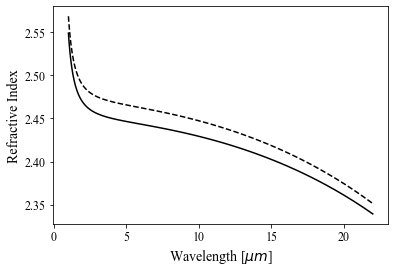

In [14]:
plt.plot(no['wl'],no['n'],'k')
plt.plot(ne['wl'],ne['n'],'k--')
plt.ylabel("Refractive Index")
plt.xlabel("Wavelength [$\mu m$]")
plt.show()

In [18]:
delta_n = ne['n']-no['n']

In [22]:
birefringence = interp1d(no['wl'], delta_n, kind='cubic')

In [49]:
def retardance(wavelength):
    d = float(birefringence(wavelength))
    return(cdse_thickness*d*1000)

## Determine Spectral Windows 

$\Delta\lambda$ is the maximum size of the window that can be used to demodulate as a function of center wavelength $\lambda_c$

In [80]:
def delta_lambda(lambda_c):
    delta = retardance(lambda_c)
    return(lambda_c**2/(delta*(1 +(lambda_c**2 / (4*delta**2)))))

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

Now, determine the spectral windows for demodulaation, returning the wavelength windows and the pixel numbers

In [81]:
lambda_c = []
lambda1  = []
lambda2  = []
pixel_c = []
pixel1  = []
pixel2  = [] 
for l in waves:
    size = delta_lambda(l)
    low  = l-size/2
    high = l+size/2
    if low > lambda_min and high < lambda_max:
        lambda_c.append(l)
        lambda1.append(low)
        lambda2.append(high)
        
        pixel_c.append(find_nearest(waves,l))
        pixel1.append(find_nearest(waves,low))
        pixel2.append(find_nearest(waves,high))

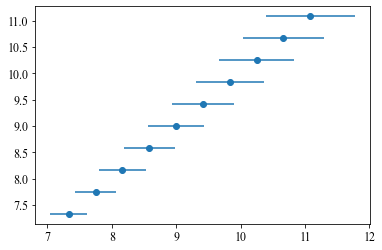

In [88]:
f, (ax1) = plt.subplots()

ax1.errorbar(lambda_c[::5],lambda_c[::5],xerr = (np.array(lambda1)- np.array(lambda2))[::5]/2,fmt = 'o')
plt.show()


## Model System Functions

In [89]:
def M(lambda_c,DOLP,AOLP,W,delta_error,offset):
    delta = 2*math.pi * retardance(lambda_c) /lambda_c
    return(DOLP*W*np.cos(delta*delta_error +2*AOLP +offset))

In [101]:
def M_array(waves,DOLP,AOLP,W,delta_error,offset):
    mod = np.zeros(len(waves))
    for i in range(len(waves)):
        m = M(waves[i],DOLP,AOLP,W,delta_error,offset)
        mod[i] = m
    return(mod)

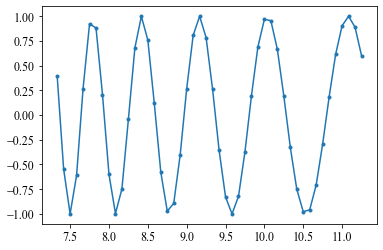

In [108]:
plt.plot(lambda_c,M_array(lambda_c,1,0,1,1,0),'.-')
plt.show()

#  Polarized Calibration

## Unpolarized Transmission

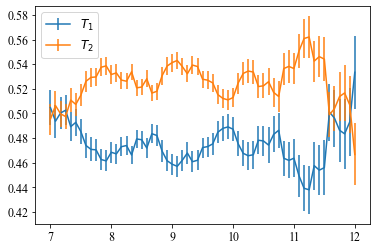

In [124]:
plt.errorbar(waves,np.mean(R1,axis = 0)/(np.mean(R1,axis = 0)+np.mean(R2,axis = 0)),yerr =np.mean(E1,axis = 0)/(np.mean(R1,axis = 0)+np.mean(R2,axis = 0)) ,label = '$T_1$')
plt.errorbar(waves,np.mean(R2,axis = 0)/(np.mean(R1,axis = 0)+np.mean(R2,axis = 0)),yerr =np.mean(E2,axis = 0)/(np.mean(R1,axis = 0)+np.mean(R2,axis = 0)) ,label = '$T_2$' )
plt.legend()
plt.show()

## Calculate AOLP dependent transmission

In [131]:

for i in range(len(angles)):
    np.max(R1[:,i]) - np.min(R1[:,i])